# Análisis de Sentimientos de reseñas de comercio con RoBERTa en Español

**Objetivo:**
- Clasificar una opinion de un producto en POSITIVA o NEGATIVA

**Tecnica y Metodos:**
- Mediante la utilizacion de la libreria transformers de [Hugging Face](https://huggingface.co/), elegi el modelo [xlm-roberta-base](https://huggingface.co/xlm-roberta-base) para realizar el procesamiento del texto y el entrenamiento agregandole dos capas neuronales para mejorar el rendimiento. El se entreno con lenguaje español.
- Como dataset se utilizó el dataset de [Amazon](https://huggingface.co/datasets/amazon_reviews_multi) donde contiene varias reviews de productos.
- Como metrica se utilizó Acurracy ya que la distribucion de los ejemplos era equilibrada.
- A pesar de haber sido entrenado con dataset de Amazon, se probo con opiniones de otras empresas coo Mercado Libre y Ebay con grandes rendimientos.

**Link de interfaz grafica del modelo:** https://huggingface.co/spaces/JuanPabloAnselmo/Analisis_Sentimientos_RoBERTa

# 1. Instalo librerías

In [ ]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 2. Importo librerias y modulos

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModelForMaskedLM, AutoModel
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap
import math
import numpy as np
import torch.nn.functional as F

# 3. Procesamiento del dataset

In [ ]:
# Inicialización
np.random.seed(42) # Elijo semilla
torch.manual_seed(42)

# Activo GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Cargar dataset
from datasets import load_dataset

dataset = load_dataset("amazon_reviews_multi", "es")

# Filtro para no tener ejemplos de 3 estrellas ya que estan en el medio
dataset = dataset.filter(lambda x : x["stars"] != 3)

# Categorizo en una variable 
# 1 o 2 estrellas = 0
# 4 o 5 estrellas = 1
def merge_star_ratings(examples):
    if examples["stars"] <= 2:
        label = 0    
    else:
        label = 1
    return {"labels": label}

#mapeo
dataset = dataset.map(merge_star_ratings)

# Paso a pandas el dataset para tener un mejor control
dataset.set_format(type="pandas")

# Train
amazon_train = dataset["train"][:]
# Hago sample de 5000 ejemplos 

amazon_train = amazon_train.sample(n=5000, random_state=42)

# Validacion
amazon_val = dataset["validation"][:]

# Test
amazon_test = dataset["test"][:]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Tamaños de las muestras
print(f"Train: {amazon_train.shape[0]}, Val: {amazon_val.shape[0]}, Test: {amazon_test.shape[0]}")

Train: 5000, Val: 4000, Test: 4000


In [ ]:
# Observo que la distribucion es equilibrada
amazon_train.labels.value_counts()

0    2541
1    2459
Name: labels, dtype: int64

# 4. Tokenización del texto  

In [ ]:
# Cargo el modelo para tokenizar el texto

model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 5. Dataset y DataLoader

In [ ]:
# Creo calse Dataset

class AmazonDataset(Dataset):

  def __init__(self,reviews,labels,tokenizer,max_len : int= 250): 
    self.reviews = reviews # Texto
    self.labels = labels # Etiquetas
    self.tokenizer = tokenizer # Tokenizer
    self.max_len = max_len #maximo de longitud de texto 250 caracteres

  def __len__(self):
      return len(self.reviews)
    
  def __getitem__(self, item):
    review = str(self.reviews[item]) # Iterador
    label = self.labels[item]
    encoding = tokenizer.encode_plus(
        review,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        padding = "max_length",
        return_attention_mask = True,
        return_tensors = 'pt'
        )
    

    return {
          'review': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      } 



In [ ]:
# Creo funcion Dataloader

def Amazon_data_loader(df, tokenizer, max_len : int= 250, batch_size : int= 16):
  dataset = AmazonDataset(
      reviews = df.review_body.to_numpy(),
      labels = df.labels.to_numpy(),
      tokenizer = tokenizer      
  )

  return DataLoader(dataset, batch_size, num_workers = 4)

In [ ]:
# Instancio los DataLoaders

train_data_loader = Amazon_data_loader(amazon_train, tokenizer)
val_data_loader = Amazon_data_loader(amazon_val, tokenizer)
test_data_loader = Amazon_data_loader(amazon_test, tokenizer)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# 6. Modelo - RoBERTa

In [ ]:
# Creo el modelo

class RobertaModel(nn.Module):

  def __init__(self, n_classes: int = 2):
    super().__init__()
    self.roberta = AutoModel.from_pretrained("xlm-roberta-base") # Transformer
    self.dropout = nn.Dropout(p=0.3) #Dropout para disminuir el overfitting
    self.linear = nn.Linear(self.roberta.config.hidden_size, self.roberta.config.hidden_size) # 1er capa linear
    self.classification = nn.Linear(self.roberta.config.hidden_size, n_classes) # 2da capa linear
   
  def forward(self, input_ids, attention_mask):
    #Roberta layer
    cls_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask) 
    pooled_output = torch.mean(cls_output.last_hidden_state, 1)

    
    # Red Nueronal   
    pooled_output = self.linear(pooled_output) # Primera capa
    pooled_output = F.relu(pooled_output) # Funcion de activacion relu
    pooled_output = self.dropout(pooled_output) # Dropout        
    output = self.classification(pooled_output) #Segunda capa

    return output




In [ ]:
# Instancio modelo
model = RobertaModel().to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# 7. Optimizacion modelo

In [ ]:
# Optimizacion y parametros de entrenamiento
EPOCHS = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.001)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = math.floor(total_steps * 0.2),
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

# 8. Loops de Train y Evaluacion

In [ ]:
# Defino funcion de loop de Train

def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids, attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double()/n_examples, np.mean(losses)

# Defino funcion de loop de Evaluacion

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids, attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double()/n_examples, np.mean(losses)

# 9. Train y Validacion

In [ ]:
from tqdm import tqdm

results = {"train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [] }


for epoch in tqdm(range(EPOCHS), desc='Epochs', unit='epoch'):
    train_acc, train_loss = train_model(
        model, train_data_loader, loss_fn, optimizer, device, scheduler, len(amazon_train)
    )
    val_acc, val_loss = eval_model(
        model, val_data_loader, loss_fn, device, len(amazon_val)
    )
    print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
    print('Validación: Loss: {}, accuracy: {}'.format(val_loss, val_acc))    
    print('')

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc.cpu())
    results["val_loss"].append(val_loss)
    results["val_acc"].append(val_acc.cpu())

Epochs:  20%|██        | 1/5 [05:10<20:43, 310.93s/epoch]

Entrenamiento: Loss: 0.48165162550374724, accuracy: 0.758
Validación: Loss: 0.3143501685075462, accuracy: 0.89875



Epochs:  40%|████      | 2/5 [10:20<15:31, 310.39s/epoch]

Entrenamiento: Loss: 0.2671507182902993, accuracy: 0.9142
Validación: Loss: 0.4261229776507244, accuracy: 0.9035



Epochs:  60%|██████    | 3/5 [15:30<10:20, 310.19s/epoch]

Entrenamiento: Loss: 0.19799879044904328, accuracy: 0.9450000000000001
Validación: Loss: 0.30657084015756847, accuracy: 0.9197500000000001



Epochs:  80%|████████  | 4/5 [20:40<05:10, 310.11s/epoch]

Entrenamiento: Loss: 0.1432221912795279, accuracy: 0.9640000000000001
Validación: Loss: 0.3425261586601846, accuracy: 0.92725



Epochs: 100%|██████████| 5/5 [25:50<00:00, 310.15s/epoch]

Entrenamiento: Loss: 0.10503748622083198, accuracy: 0.9770000000000001
Validación: Loss: 0.40620650989818385, accuracy: 0.9255



Se evidencia un Accuracy mayor al 90% en Train y validacion con una perdida muy baja. Gran rendiemiento del modelo

# 10. Gráfico de Loss y Accuracy

In [ ]:
# Creo funciones

import matplotlib.pyplot as plt

def plot_loss(train_loss, val_loss):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Loss - Train vs Val")
    ax.plot(train_loss, label="Loss Train")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax2 = ax.twinx()
    ax2.plot(val_loss, label="Loss Val", color="orange")    
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")      
    ax.grid(True)
    plt.show()

def plot_accuracy(train_acc, val_acc):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Accuracy - Train vs Val")
    ax.plot(train_acc, label="Accuracy Train")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax2 = ax.twinx()
    ax2.plot(val_acc, label="Accuracy Val", color="orange")    
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")    
    ax.grid(True)
    plt.show()

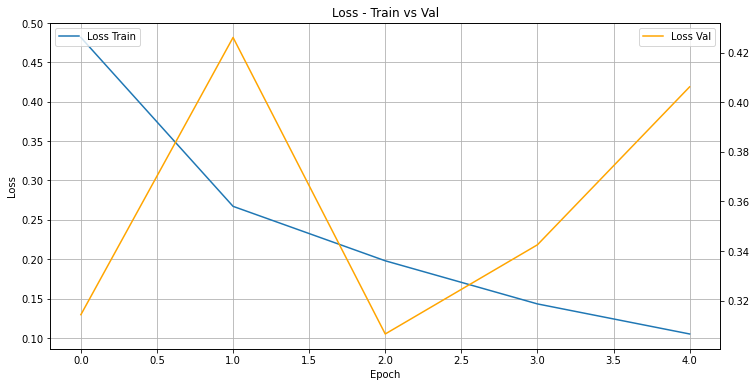

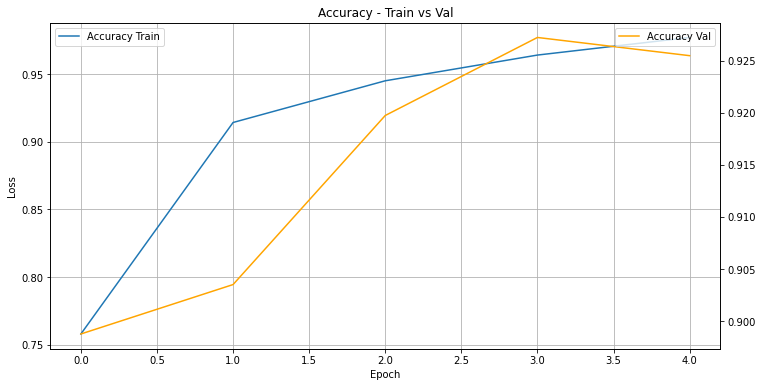

In [ ]:
plot_loss(results["train_loss"], results["val_loss"])
plot_accuracy(results["train_acc"], results["val_acc"])

**Loss:** En el epoch 2 se evidencia la menor perdida del conjunto de validacion, luego comienza a aumentar pero siempre manteniendo un valor muy bajo

**Accuracy:** Se evidencia un aumento de Acurracy en ambos conjuntos ( Train y Validacion) con un valor mayor al 90%, no se observa overfitting.

# 11. Evaluacion de Test

In [ ]:
test_acc, test_loss = eval_model(
    model, test_data_loader, loss_fn, device, len(amazon_test))

print('Test: Loss: {}, accuracy: {}'.format(test_loss, test_acc))

Test: Loss: 0.4140483306741808, accuracy: 0.9225


Se evidencia nuevamente un gran rendimiento (Accuracy mayor a 90%) en el conjunto de Test

# 12. Salvar modelo

Se guarda en el inicio de Google Drive

In [ ]:
# Doy permisos para guardar en el Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Guardo el modelo

PATH = "/content/drive/My Drive/Modelo_Amazon_review.pt"

torch.save(model.state_dict(), PATH)

# 13. Evaluacion con texto propio

In [ ]:
# Creo una funcion para colocar el review y comprobar si es positivo o negativo

def ClasificacionSentimiento(review_text):
    encoding_review = tokenizer.encode_plus(
        review_text,
        max_length = 250,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        padding = "max_length",
        return_attention_mask = True,
        return_tensors = 'pt'
        )
    
    input_ids = encoding_review['input_ids'].to(device)
    attention_mask = encoding_review['attention_mask'].to(device)
    output = model(input_ids, attention_mask)    
    _, prediction = torch.max(output, dim=1)
    print("\n".join(wrap(review_text)))
    print(prediction)
    if prediction == 0:
        print('Sentimiento predicho: NEGATIVO')
    else:
        print('Sentimiento predicho: POSITIVO')


  

In [ ]:
# Implementacion 

text = "El producto no tiene un olor fuerte. Lo compré para probarlo porque era más barato que el popopurrí. Prefiero pagar el costo más alto ahora. Tampoco dura mucho. Simplemente no vale la pena para mí."
ClasificacionSentimiento(text)

El producto no tiene un olor fuerte. Lo compré para probarlo porque
era más barato que el popopurrí. Prefiero pagar el costo más alto
ahora. Tampoco dura mucho. Simplemente no vale la pena para mí.
tensor([0], device='cuda:0')
Sentimiento predicho: NEGATIVO


# 14. Conclusión

El rendimiento del modelo con los 3 conjuntos del dataset fue muy bueno con un Accuracy mayor al 90%. 

Aunque fue entrenado con un dataset de Amazon, se probo con reviews de otras paginas como Mercado Libre y Ebay con grandes resultados.

Se creo interfaz grafica para poder utilizar el modelo: https://huggingface.co/spaces/JuanPabloAnselmo/Analisis_Sentimientos_RoBERTa